# TESS EDA Notebook

This notebook is for quick EDA of streaming photometry outputs.
It loads the latest `*_photometry.csv` under `data/tess/` and
produces quality checks, basic statistics, and sample lightcurves.

Notes:
- Streaming outputs may use `mjd` for BTJD; this notebook creates a `btjd` column when needed.
- Quality flag meanings are in `CLAUDE.md` and `StreamingPipeline.py`.


In [24]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_theme(style="whitegrid")
except Exception:
    sns = None

plt.rcParams["figure.figsize"] = (10, 4)


In [25]:
from pathlib import Path

def find_project_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "pyproject.toml").exists() or ((p / "src").exists() and (p / "data").exists()):
            return p
    return start

PROJECT_ROOT = find_project_root(Path.cwd())
DATA_DIR = PROJECT_ROOT / "data"
PROJECT_ROOT

def pick_latest(paths):
    return max(paths, key=lambda p: p.stat().st_mtime) if paths else None

photometry_paths = list(DATA_DIR.glob("tess/sector_*/cam*_ccd*/s*_photometry.csv"))
if not photometry_paths:
    photometry_paths = list(DATA_DIR.glob("tess/sector_*/cam*_ccd*/s*_photometry.parquet"))

photometry_path = pick_latest(photometry_paths)
photometry_path

# Optional: manually set a specific file
# photometry_path = PROJECT_ROOT / "data/tess/sector_070/cam1_ccd1/s0070_1-1_photometry.csv"


WindowsPath('c:/Users/kiril/OneDrive/Desktop/My_projects/TESS_project-main/data/tess/sector_070/cam1_ccd1/s0070_1-1_photometry.csv')

In [26]:
if photometry_path is None:
    raise FileNotFoundError("No photometry files found under data/tess/...")

if photometry_path.suffix == ".parquet":
    df = pd.read_parquet(photometry_path)
else:
    df = pd.read_csv(photometry_path)

# Normalize column names for analysis
if "quality_flag" not in df and "quality" in df:
    df["quality_flag"] = df["quality"]
if "btjd" not in df and "mjd" in df:
    df["btjd"] = df["mjd"]

# Related metadata (if present)
base = photometry_path.name.split("_photometry")[0]
summary_path = photometry_path.with_name(f"{base}_summary.json")
catalog_path = photometry_path.with_name(f"{base}_catalog.json")

summary = json.load(open(summary_path, "r")) if summary_path.exists() else None
catalog = json.load(open(catalog_path, "r")) if catalog_path.exists() else None

print(f"Loaded: {photometry_path}")
print(f"Rows: {len(df):,}  Stars: {df['star_id'].nunique():,}  Epochs: {df['epoch'].nunique():,}")
if summary:
    print("Summary:", summary)
if catalog:
    print(f"Catalog stars: {catalog.get('n_stars')}  epochs: {catalog.get('n_epochs')}")

df.head()


Loaded: c:\Users\kiril\OneDrive\Desktop\My_projects\TESS_project-main\data\tess\sector_070\cam1_ccd1\s0070_1-1_photometry.csv
Rows: 3,983,949  Stars: 2,217  Epochs: 1,789
Summary: {'session_id': 's0070_1-1', 'sector': 70, 'camera': '1', 'ccd': '1', 'n_stars': 2217, 'n_epochs': 1797, 'n_measurements': 3983949, 'files_processed': 1797, 'btjd_start': 3208.383925660183, 'btjd_end': 3233.8207746025723, 'time_span_days': 25.436848942389133, 'good_measurements': 3698789, 'completeness': 0.9284227785044437}
Catalog stars: 2217  epochs: 1797


,star_id,epoch,mjd,flux,flux_error,quality,x,y,btjd,quality_flag
0,STAR_000000,0,3208.356148,-8.432679,0.464930,2,118.127314,1.252363,NaN,2
1,STAR_000001,0,3208.356148,-7.962547,0.454339,2,385.422666,1.348834,NaN,2
2,STAR_000002,0,3208.356148,-8.533896,0.448998,2,454.114088,0.941508,NaN,2
3,STAR_000003,0,3208.356148,29.392210,0.452774,1,1441.523779,0.385098,NaN,1
4,STAR_000004,0,3208.356148,6.057578,0.432641,1,690.549726,3.799721,NaN,1


## Basic dataset stats


In [27]:
n_stars = df["star_id"].nunique()
n_epochs = df["epoch"].nunique()
n_measurements = len(df)
n_good = (df["quality_flag"] == 0).sum()
completeness = n_good / n_measurements if n_measurements else 0

stats = {
    "n_stars": n_stars,
    "n_epochs": n_epochs,
    "n_measurements": n_measurements,
    "n_good": int(n_good),
    "completeness": completeness,
}
stats


{'n_stars': 2217,
 'n_epochs': 1789,
 'n_measurements': 3983949,
 'n_good': 3698789,
 'completeness': np.float64(0.9284227785044437)}

## Quality flags


In [28]:
quality_counts = df["quality_flag"].value_counts().sort_index()
quality_counts


quality_flag
0    3698789
1       9962
2     221541
3      53657
Name: count, dtype: int64

Text(0.5, 1.0, 'Quality flag distribution')

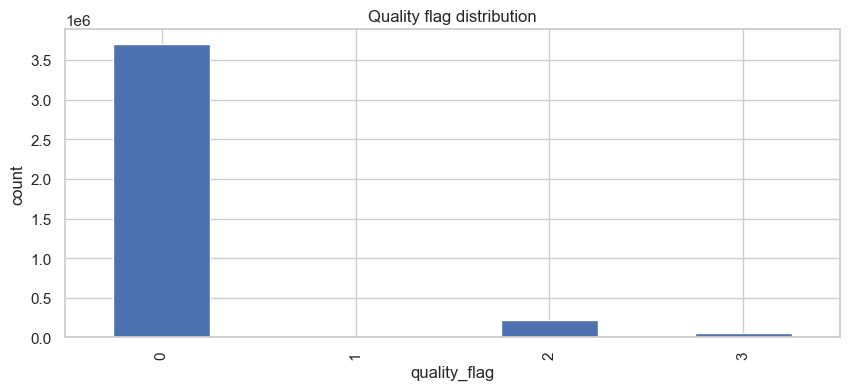

In [29]:
ax = quality_counts.plot(kind="bar")
ax.set_xlabel("quality_flag")
ax.set_ylabel("count")
ax.set_title("Quality flag distribution")


## Time coverage and cadence


In [30]:
btjd = df["btjd"].dropna().values
btjd_min = float(np.min(btjd)) if len(btjd) else np.nan
btjd_max = float(np.max(btjd)) if len(btjd) else np.nan
time_span_days = btjd_max - btjd_min if len(btjd) else np.nan

unique_times = np.sort(df["btjd"].dropna().unique())
median_cadence_days = np.median(np.diff(unique_times)) if len(unique_times) > 1 else np.nan

{
    "btjd_start": btjd_min,
    "btjd_end": btjd_max,
    "time_span_days": time_span_days,
    "median_cadence_days": median_cadence_days,
}


{'btjd_start': 3208.383925660183,
 'btjd_end': 3233.8207746025723,
 'time_span_days': 25.436848942389133,
 'median_cadence_days': np.float64(0.013888551866784837)}

## Flux, errors, and SNR


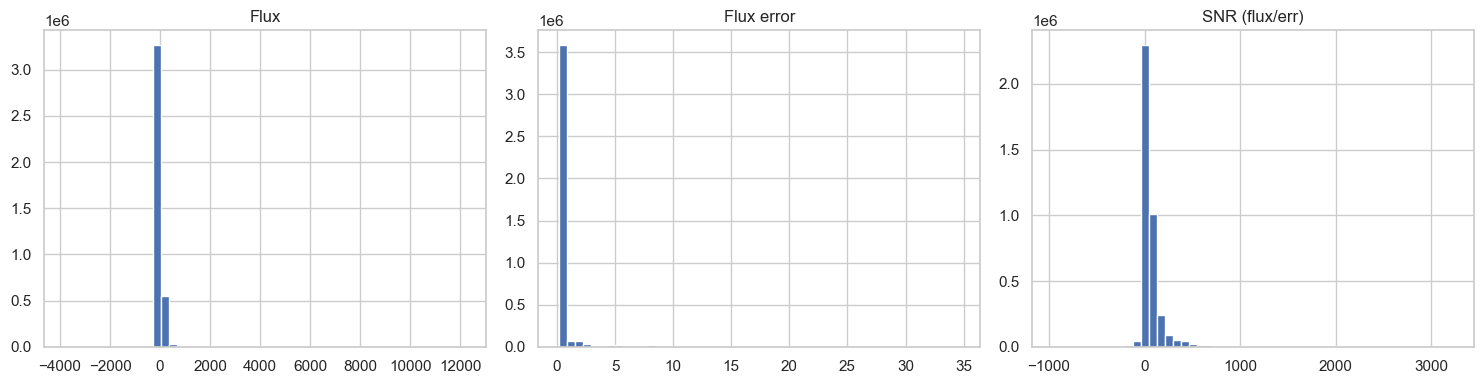

In [31]:
df["snr"] = np.where(df["flux_error"] > 0, df["flux"] / df["flux_error"], np.nan)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(df["flux"].dropna(), bins=50)
axes[0].set_title("Flux")

axes[1].hist(df["flux_error"].dropna(), bins=50)
axes[1].set_title("Flux error")

axes[2].hist(df["snr"].dropna(), bins=50)
axes[2].set_title("SNR (flux/err)")
plt.tight_layout()


## Per-star metrics


In [32]:
good = df[df["quality_flag"] == 0].copy()

def robust_amp(x):
    med = np.median(x)
    if med == 0:
        return np.nan
    p5, p95 = np.percentile(x, [5, 95])
    return (p95 - p5) / med

per_star = good.groupby("star_id").agg(
    n_good=("epoch", "size"),
    median_flux=("flux", "median"),
    mad_flux=("flux", lambda x: np.median(np.abs(x - np.median(x)))),
    amp_robust=("flux", robust_amp),
    median_snr=("snr", "median"),
)

n_obs = df.groupby("star_id")["epoch"].size().rename("n_obs")
per_star = per_star.join(n_obs, how="left")
per_star["completeness"] = per_star["n_good"] / per_star["n_obs"]

per_star.head()


,n_good,median_flux,mad_flux,amp_robust,median_snr,n_obs,completeness
star_id,,,,,,,
STAR_000008,1,6.620403,0.000000,0.000000,15.186768,1797,0.000556
STAR_000009,1,5.143118,0.000000,0.000000,11.846986,1797,0.000556
STAR_000010,1776,3376.409353,18.991199,0.031282,1856.239318,1797,0.988314
STAR_000011,1773,7.095683,0.104600,0.090085,38.174286,1797,0.986644
STAR_000012,1769,3.546564,0.056090,0.186780,19.864503,1797,0.984418


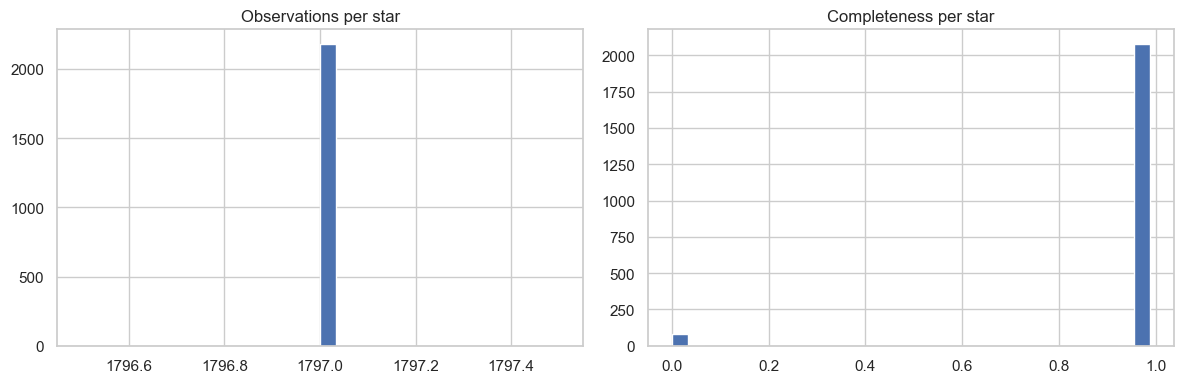

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
per_star["n_obs"].hist(bins=30, ax=axes[0])
axes[0].set_title("Observations per star")

per_star["completeness"].hist(bins=30, ax=axes[1])
axes[1].set_title("Completeness per star")
plt.tight_layout()


## Per-epoch coverage


Text(0, 0.5, 'count')

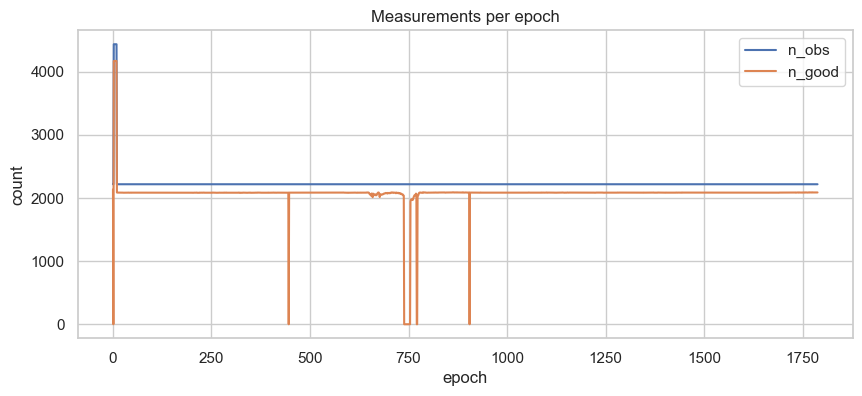

In [34]:
per_epoch = df.groupby("epoch").agg(
    n_obs=("star_id", "size"),
    n_good=("quality_flag", lambda x: (x == 0).sum()),
)

ax = per_epoch.plot()
ax.set_title("Measurements per epoch")
ax.set_xlabel("epoch")
ax.set_ylabel("count")


## Sample lightcurves


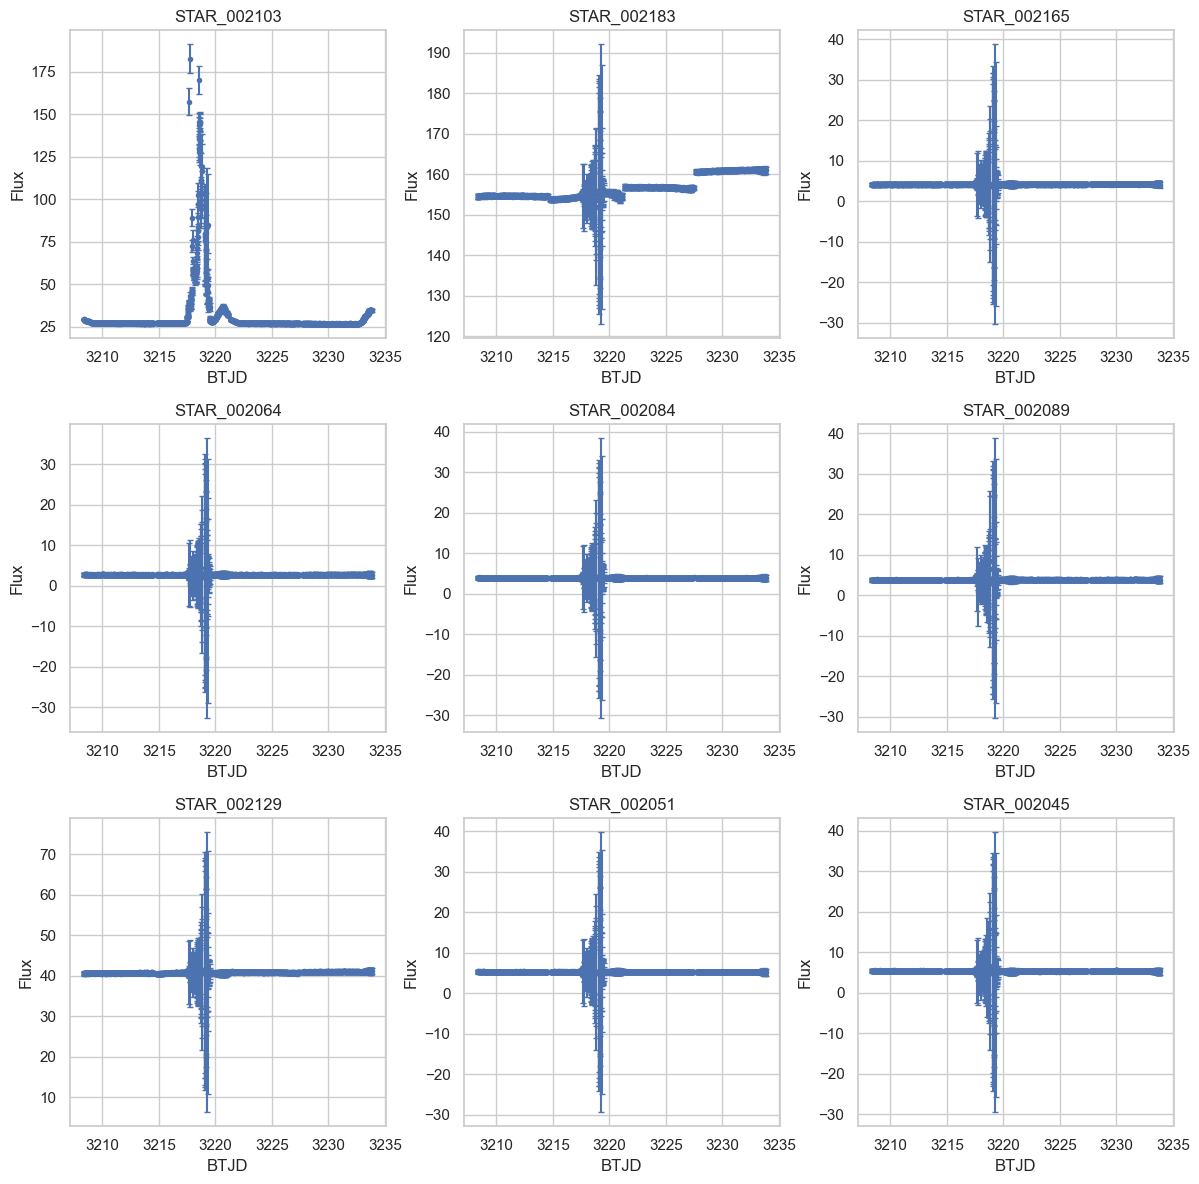

In [35]:
if len(per_star) == 0:
    raise ValueError("No stars to plot")

candidate_ids = per_star.sort_values("n_good", ascending=False).head(200)
n_samples = min(9, len(candidate_ids))
sample_ids = candidate_ids.sample(n_samples, random_state=42).index

cols = 3
rows = int(np.ceil(n_samples / cols))
fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
axes = np.atleast_1d(axes).reshape(-1)

for ax, star_id in zip(axes, sample_ids):
    lc = df[df["star_id"] == star_id]
    good_lc = lc[lc["quality_flag"] == 0]
    ax.errorbar(
        good_lc["btjd"],
        good_lc["flux"],
        yerr=good_lc["flux_error"],
        fmt="o",
        markersize=3,
        capsize=2,
    )
    ax.set_title(star_id)
    ax.set_xlabel("BTJD")
    ax.set_ylabel("Flux")

# Hide unused subplots
for ax in axes[len(sample_ids):]:
    ax.axis("off")

plt.tight_layout()


## Top robust amplitudes (quick anomaly scan)


In [36]:
per_star.sort_values("amp_robust", ascending=False).head(15)


,n_good,median_flux,mad_flux,amp_robust,median_snr,n_obs,completeness
star_id,,,,,,,
STAR_002085,1776,1.369520,0.060388,28.180088,8.138456,1797,0.988314
STAR_000132,23,1.658962,1.474535,23.722849,0.088757,1797,0.012799
STAR_000825,5,3.575312,2.946295,21.702427,2.678574,1797,0.002782
STAR_000070,20,6.048207,5.785892,17.625049,0.319819,1797,0.011130
STAR_001020,14,0.274892,0.190999,16.281042,0.032367,1797,0.007791
STAR_001545,115,0.018010,0.011857,14.680038,0.059278,1797,0.063996
STAR_002216,1776,12.004350,0.360755,14.398822,73.223091,1797,0.988314
STAR_002209,1776,6.091865,0.168747,10.557258,39.295671,1797,0.988314
STAR_001567,1776,14.569446,0.199522,10.024138,73.425025,1797,0.988314


## TIC Cross-match Statistics

Load TIC IDs and merge with per-star metrics to analyze stellar properties.

In [37]:
# Load TIC IDs
tic_path = photometry_path.with_name(photometry_path.name.replace("_photometry.csv", "_tic_ids.csv"))

if tic_path.exists():
    tic_df = pd.read_csv(tic_path)
    print(f"Loaded TIC IDs: {tic_path}")
    print(f"Stars with TIC: {len(tic_df)}")
    
    # Merge with per_star stats
    per_star_tic = per_star.reset_index().merge(tic_df, on="star_id", how="left")
    per_star_tic = per_star_tic.set_index("star_id")
    
    print(f"\nTIC separation stats (arcsec):")
    print(per_star_tic["tic_separation_arcsec"].describe())
else:
    print(f"TIC IDs file not found: {tic_path}")
    print("Run TIC cross-matching first or create the file manually.")
    per_star_tic = None

Loaded TIC IDs: c:\Users\kiril\OneDrive\Desktop\My_projects\TESS_project-main\data\tess\sector_070\cam1_ccd1\s0070_1-1_tic_ids.csv
Stars with TIC: 2217

TIC separation stats (arcsec):
count    2177.000000
mean       29.996699
std        12.924846
min         0.123695
25%        20.011351
50%        30.107229
75%        41.532462
max        62.239278
Name: tic_separation_arcsec, dtype: float64


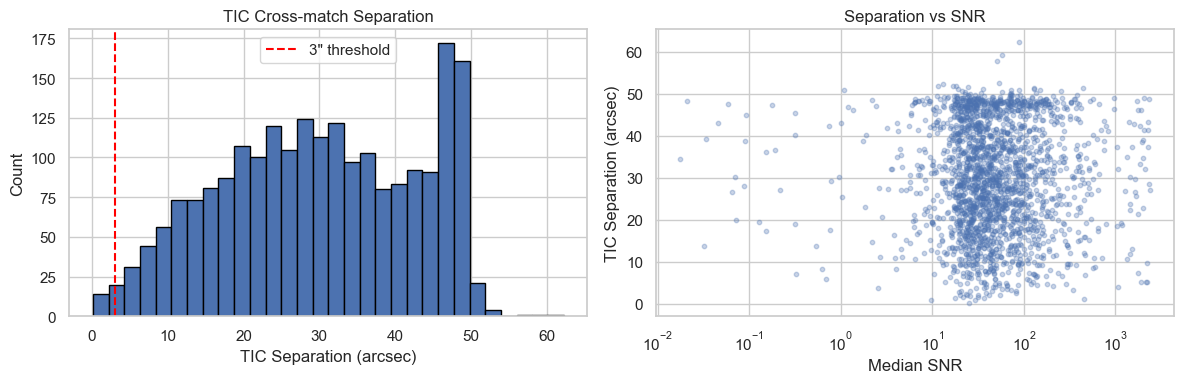

In [38]:
# TIC separation distribution
if per_star_tic is not None:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Separation histogram
    per_star_tic["tic_separation_arcsec"].hist(bins=30, ax=axes[0], edgecolor="black")
    axes[0].set_xlabel("TIC Separation (arcsec)")
    axes[0].set_ylabel("Count")
    axes[0].set_title("TIC Cross-match Separation")
    axes[0].axvline(3.0, color="red", ls="--", label="3\" threshold")
    axes[0].legend()
    
    # Separation vs SNR
    axes[1].scatter(per_star_tic["median_snr"], per_star_tic["tic_separation_arcsec"], 
                    alpha=0.3, s=10)
    axes[1].set_xlabel("Median SNR")
    axes[1].set_ylabel("TIC Separation (arcsec)")
    axes[1].set_title("Separation vs SNR")
    axes[1].set_xscale("log")
    
    plt.tight_layout()

In [39]:
# Top variable candidates with TIC IDs
if per_star_tic is not None:
    # Filter to high-completeness stars
    good_stars = per_star_tic[per_star_tic["completeness"] > 0.8]
    
    # Top by robust amplitude
    top_vars = good_stars.nlargest(15, "amp_robust")[
        ["tic_id", "amp_robust", "median_snr", "completeness", "tic_separation_arcsec"]
    ]
    top_vars["amp_robust_pct"] = (top_vars["amp_robust"] * 100).round(2)
    top_vars["tic_link"] = top_vars["tic_id"].apply(
        lambda x: f"https://exofop.ipac.caltech.edu/tess/target.php?id={x}"
    )
    
    print("Top 15 Variable Candidates (completeness > 80%):")
    display(top_vars[["tic_id", "amp_robust_pct", "median_snr", "completeness"]])

Top 15 Variable Candidates (completeness > 80%):


,tic_id,amp_robust_pct,median_snr,completeness
star_id,,,,
STAR_002085,2052419680,2818.01,8.138456,0.988314
STAR_002216,301258417,1439.88,73.223091,0.988314
STAR_002209,2052355517,1055.73,39.295671,0.988314
STAR_001567,2052450624,1002.41,73.425025,0.988314
STAR_002215,49709807,981.00,50.885133,0.988314
STAR_001671,117546716,848.31,33.004884,0.988314
STAR_002208,92137242,790.37,53.154033,0.988314
STAR_002212,8918936,755.49,58.113600,0.988314
STAR_002042,2052636881,629.76,18.547707,0.988314


### TIC Lookup Links

To view detailed stellar parameters for any star, use:
- **ExoFOP-TESS**: `https://exofop.ipac.caltech.edu/tess/target.php?id={TIC_ID}`
- **MAST Portal**: `https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html?searchQuery={TIC_ID}`

The TIC catalog contains: Teff, log(g), radius, mass, luminosity class, proper motion, and more.

## Optional: exported feature set (if present)


In [40]:
features_dir = DATA_DIR / "exports" / "features"
feature_paths = list(features_dir.glob("*_features.csv"))

if feature_paths:
    feat_path = pick_latest(feature_paths)
    feats = pd.read_csv(feat_path)
    print(f"Loaded features: {feat_path}")
    feats.head()
else:
    print("No exported features found under data/exports/features")


Loaded features: c:\Users\kiril\OneDrive\Desktop\My_projects\TESS_project-main\data\exports\features\test_export_features.csv


## Optional: exported timeseries arrays (if present)


In [41]:
ts_dir = DATA_DIR / "exports" / "timeseries"
ts_paths = list(ts_dir.glob("*_timeseries.npz"))

if ts_paths:
    ts_path = pick_latest(ts_paths)
    ts = np.load(ts_path)
    print(f"Loaded timeseries: {ts_path}")
    print("X shape:", ts["X"].shape)
    print("mask shape:", ts["mask"].shape)
else:
    print("No timeseries arrays found under data/exports/timeseries")


Loaded timeseries: c:\Users\kiril\OneDrive\Desktop\My_projects\TESS_project-main\data\exports\timeseries\test_export_timeseries.npz
X shape: (2108, 200, 3)
mask shape: (2108, 200)


## Epoch Quality Control

Visualize data quality over time to identify problematic periods (e.g., lunar scattered light).

array([<Axes: xlabel='btjd'>, <Axes: xlabel='btjd'>,
       <Axes: xlabel='btjd'>, <Axes: xlabel='btjd'>], dtype=object)

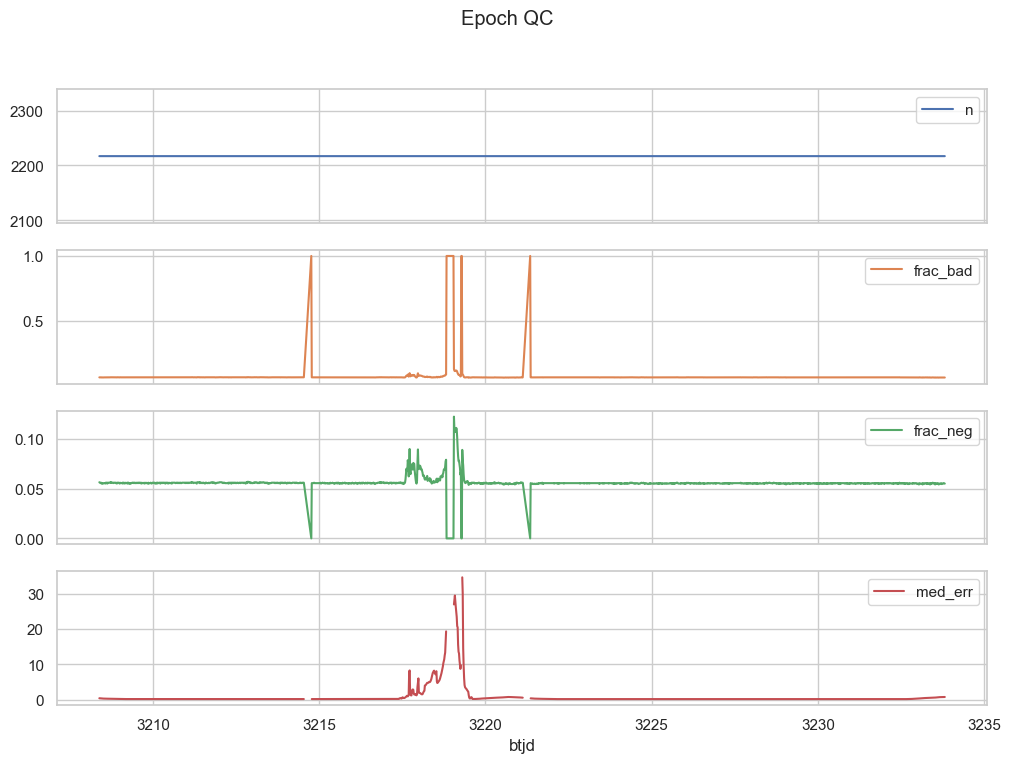

In [42]:
epoch_qc = df.groupby("btjd").agg(
    n=("star_id","size"),
    frac_bad=("quality_flag", lambda s: (s!=0).mean()),
    frac_neg=("flux", lambda s: (s<0).mean()),
    med_err=("flux_error","median"),
).sort_index()
epoch_qc.plot(subplots=True, figsize=(12,8), title="Epoch QC")


## Next steps

- Increase epochs for stronger periodicity detection and better ML features.
- Inspect high `amp_robust` and low-completeness stars manually.
- Export a curated labeled set for supervised classification.
